In [1]:
import os
import time
import numpy as np
import pickle
import pytz
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
samples_directory = './embeddings'
all_items = os.listdir(samples_directory)
sample_files = [f"{samples_directory}/{item}" for item in all_items if os.path.isfile(f"{samples_directory}/{item}")]
print(f"Files num: {len(sample_files)}.")

Files num: 56.


In [3]:
def load_emb(file_name):
    # 加载embeddings
    with open(f"{file_name}", 'rb') as f:
        loaded_emb = pickle.load(f)

    # 拼接embeddings
    concat_emb = np.vstack(loaded_emb)
    return concat_emb

In [4]:
print(sample_files[0])

./embeddings/embeddings_1632000_1663999_2024-12-04_15:52:10.pkl


In [5]:
def clustering_all_embeddings(n_clusters=1000, batch_size=10000):
    flag_fit_transform = False
    all_tokens_num = 0

    mbk = MiniBatchKMeans(n_clusters=n_clusters, n_init='auto', batch_size=batch_size)
    scaler = StandardScaler()

    for i, file_name in enumerate(sample_files):
        print(f"----- The {i+1} clustering -----")
        print(f"Loading embeddings from file({file_name})...")
        embs = load_emb(file_name)
        all_tokens_num = all_tokens_num + len(embs)
        print(f"Loaded {len(embs)} tokens.")

        # fit_transform只执行一次, 确保所有数据都按照相同的规则进行缩放
        start_time = time.time()
        if not flag_fit_transform:
            embs_scaled = scaler.fit_transform(embs)
            flag_fit_transform = True
        else:
            embs_scaled = scaler.transform(embs)
        end_time = time.time()
        print(f"Transform embeddings has done, using {(end_time - start_time):.3f}s.")

        # 部分聚类
        start_time = time.time()
        mbk.partial_fit(embs_scaled)
        end_time = time.time()
        print(f"Clustering partial embeddings has done, using {(end_time - start_time):.3f}s.")
        print(f"Cumulative tokens: {all_tokens_num}.\n")

    print(f"\n\nAll clustering has done.")

    return mbk, scaler

In [6]:
def save_clustering_result(mbk, scaler):
    directory_path = './clustering'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_name = f"{directory_path}/clustering_result.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump((mbk, scaler), f)

def load_clustering_result():
    file_name = './clustering/clustering_result.pkl'

    # 加载embeddings
    with open(f"{file_name}", 'rb') as f:
        loaded_clustering_ret = pickle.load(f)

    return loaded_clustering_ret


In [7]:
# 读取所有文件中的embeddings并进行聚类
mbk, scaler = clustering_all_embeddings()
final_centers = mbk.cluster_centers_

save_clustering_result(mbk, scaler)

----- The 1 clustering -----
Loading embeddings from file(./embeddings/embeddings_1632000_1663999_2024-12-04_15:52:10.pkl)...
Loaded 2100143 tokens.
Transform embeddings has done, using 9.402s.
Clustering partial embeddings has done, using 61.937s.
Cumulative tokens: 2100143.

----- The 2 clustering -----
Loading embeddings from file(./embeddings/embeddings_1728000_1759999_2024-12-04_15:52:57.pkl)...
Loaded 2066971 tokens.
Transform embeddings has done, using 3.247s.
Clustering partial embeddings has done, using 9.318s.
Cumulative tokens: 4167114.

----- The 3 clustering -----
Loading embeddings from file(./embeddings/embeddings_352000_383999_2024-12-04_15:41:36.pkl)...
Loaded 2089176 tokens.
Transform embeddings has done, using 3.637s.
Clustering partial embeddings has done, using 8.586s.
Cumulative tokens: 6256290.

----- The 4 clustering -----
Loading embeddings from file(./embeddings/embeddings_1248000_1279999_2024-12-04_15:49:00.pkl)...
Loaded 2058375 tokens.
Transform embeddings 

In [8]:
def evaluate_clustering_ret(embs, mbk, scaler, sample_size=10000):
    embs_scaled = scaler.transform(embs)
    labels = mbk.predict(embs_scaled)

    # 使用子样本进行评估
    if len(embs) > sample_size:
        indices = np.random.choice(len(embs), size=sample_size, replace=False)
        subsample_embs = embs[indices]
        subsample_labels = labels[indices]
    else:
        subsample_embs = embs
        subsample_labels = labels

    score1 = silhouette_score(subsample_embs, subsample_labels)
    score2 = calinski_harabasz_score(subsample_embs, subsample_labels)
    score3 = davies_bouldin_score(subsample_embs, subsample_labels)

    return [score1, score2, score3]

def cal_average_scores(scores_all):
    ave_scores = [0, 0, 0]

    for i in range(scores_all.shape[1]):
        ave_score = np.mean(scores_all[:, i])
        ave_scores[i] = ave_score
    
    return ave_scores

In [9]:
def draw_scores(scores_all):
    scores_all = np.array(scores_all)
    x = list(range(1, len(scores_all) + 1))

    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    plt.suptitle('Scores of Mini Batch K-Means Clustering of Embeddings')

    # 第一个子图：Silhouette Score
    y = scores_all[:, 0]
    axs[0].plot(x, y, marker='o', linestyle='-', color='b', label='Silhouette Score')
    axs[0].set_title('Silhouette Score (near to 1 is better)')
    axs[0].set_xlabel('Embeddings batch idx')
    axs[0].set_ylabel('Silhouette Score')
    axs[0].legend()

    # 第二个子图：Calinski-Harabasz Index
    y = scores_all[:, 1]
    axs[1].plot(x, y, marker='o', linestyle='-', color='g', label='Calinski-Harabasz Index')
    axs[1].set_title('Calinski-Harabasz Index (bigger is better)')
    axs[1].set_xlabel('Embeddings batch idx')
    axs[1].set_ylabel('Calinski-Harabasz Index')
    axs[1].legend()

    # 第三个子图：Davies-Bouldin Index
    y = scores_all[:, 2]
    axs[2].plot(x, y, marker='o', linestyle='-', color='r', label='Davies-Bouldin Index')
    axs[2].set_title('Davies-Bouldin Index (smaller is better)')
    axs[2].set_xlabel('Embeddings batch idx')
    axs[2].set_ylabel('Davies-Bouldin Index')
    axs[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # rect 参数用于调整标题的位置
    plt.show()

In [10]:
def evaluate_all_clustering_ret():
    mbk, scaler = load_clustering_result()
    print("Load clustering result finished.")

    scores_all = []
    #  再次遍历所有embeddings文件, 并预测每个样本的标签, 并进行评估聚类结果
    for i, file_name in enumerate(sample_files):
        print(f"----- The {i+1} clustering -----")
        embs = load_emb(file_name)
        print(f"Loading embeddings from file({file_name}) done.")

        scores = evaluate_clustering_ret(embs, mbk, scaler, sample_size=50000)
        print("Evaluate clustering result has done:")
        print(f"    silhouette score: {scores[0]:.3f}, calinski harabasz score: {scores[1]:.3f}, davies bouldin score: {scores[2]:.3f}.")
        scores_all.append(scores)
        
    scores_all = np.array(scores_all)

    ave_scores = cal_average_scores(scores_all)
    print(f"\nAverage scores:")
    print(f"    silhouette score: {ave_scores[0]:.3f}, calinski harabasz score: {ave_scores[1]:.3f}, davies bouldin score: {ave_scores[2]:.3f}.")
    
    draw_scores(scores_all)


Load clustering result finished.
----- The 1 clustering -----
Loading embeddings from file(./embeddings/embeddings_1632000_1663999_2024-12-04_15:52:10.pkl) done.
Evaluate clustering result has done:
    silhouette score: 0.206, calinski harabasz score: 125.851, davies bouldin score: 2.354.
----- The 2 clustering -----
Loading embeddings from file(./embeddings/embeddings_1728000_1759999_2024-12-04_15:52:57.pkl) done.
Evaluate clustering result has done:
    silhouette score: 0.212, calinski harabasz score: 127.587, davies bouldin score: 2.313.
----- The 3 clustering -----
Loading embeddings from file(./embeddings/embeddings_352000_383999_2024-12-04_15:41:36.pkl) done.
Evaluate clustering result has done:
    silhouette score: 0.215, calinski harabasz score: 126.714, davies bouldin score: 2.234.
----- The 4 clustering -----
Loading embeddings from file(./embeddings/embeddings_1248000_1279999_2024-12-04_15:49:00.pkl) done.
Evaluate clustering result has done:
    silhouette score: 0.204, 

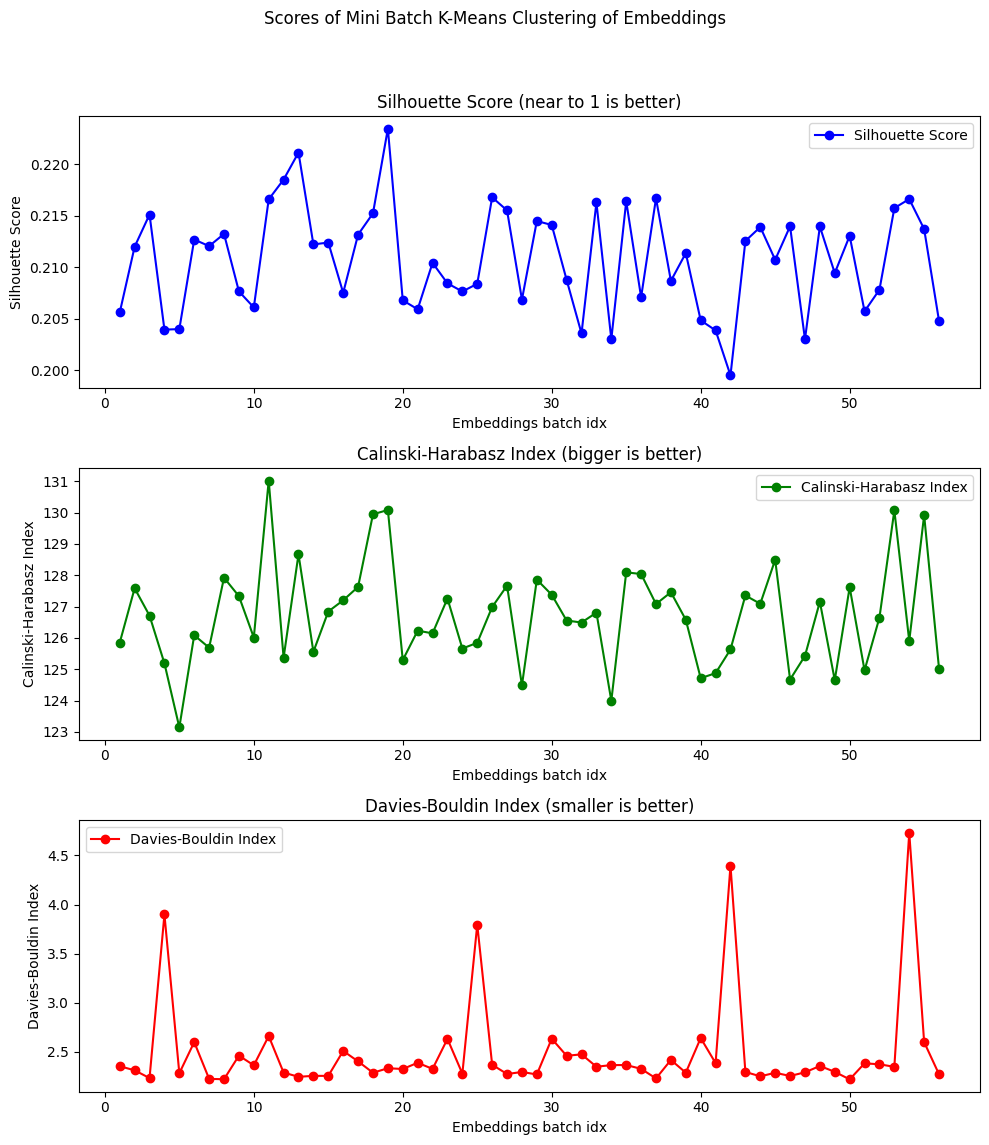

In [11]:
evaluate_all_clustering_ret()